In [1]:
import time
import sys, os, collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('../')
sys.path.append('/usr/users/fsimone/tejaas')

import mpmath
mpmath.mp.dps = 40
def pval(x): return float(1 - 0.5 * (1 + mpmath.erf(x/mpmath.sqrt(2))))

SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'p', 'logp']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()

def tejaas(filepath, chrom):
    res = list()
    rownums = list()
    counter = -1
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            pos   = int(arr[1])
            p     = float(arr[5])
            q     = float(arr[2])
            mu    = float(arr[3])
            sigma = float(arr[4])
            counter += 1
            if sigma == 0:
                continue
            if p<=1e-2:
                rownums.append(counter)
                logp  = np.log10(p) if p != 0 else pval( (q - mu) / sigma)
                res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, p=p, logp=-logp))
    return res, rownums
    
def normalize_betas(Y):
    if isinstance(Y, pd.DataFrame):
        Y_cent = (Y.values - np.mean(Y.values, axis = 1).reshape(-1, 1)) / np.std(Y.values, axis = 1).reshape(-1, 1)
        Y_cent = pd.DataFrame(Y_cent, index=Y.index, columns=Y.columns)
        Y_cent.index.name = Y.index.name
    else:
        Y_cent = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return Y_cent

def load_betas(infile, rownums):
    values = list()
    rowdict = collections.defaultdict(lambda: False)
    for i in rownums:
        rowdict[i] = True
    with open(infile) as instream:
        next(instream)
        for i,line in enumerate(instream):
            if rowdict[i]:
                values.append([np.float(x) for x in line.rstrip().split()])
    return np.array(values)

def load_betas_easy(infile):
    df = pd.read_csv(infile, header=0, sep=" ")
    return df.values

In [2]:
ldfile="/cbscratch/franco/datasets/gtex_v8/genotypes/ldmap_200000_0.5/chr{:d}_gtex_v8.geno.ld"
# myldict = read_ldfile(ldfile.format(CHROM))
LD_gw_dict = dict()
start = time.time()
chroms = np.arange(1,23)
for chrm in chroms:
    print("Loading CHR ", chrm, end="")
    myldict = read_ldfile(ldfile.format(chrm))
    LD_gw_dict[chrm] = myldict
    took = time.time() - start
    print(" - {:g} seconds".format(took))

Loading CHR  1 - 9.03054 seconds
Loading CHR  2 - 18.6319 seconds
Loading CHR  3 - 26.2105 seconds
Loading CHR  4 - 33.8519 seconds
Loading CHR  5 - 41.0252 seconds
Loading CHR  6 - 49.2964 seconds
Loading CHR  7 - 55.6362 seconds
Loading CHR  8 - 63.0659 seconds
Loading CHR  9 - 67.526 seconds
Loading CHR  10 - 75.0391 seconds
Loading CHR  11 - 80.5951 seconds
Loading CHR  12 - 85.7216 seconds
Loading CHR  13 - 88.9942 seconds
Loading CHR  14 - 94.4195 seconds
Loading CHR  15 - 97.5952 seconds
Loading CHR  16 - 101.263 seconds
Loading CHR  17 - 104.802 seconds
Loading CHR  18 - 107.398 seconds
Loading CHR  19 - 110.038 seconds
Loading CHR  20 - 114.723 seconds
Loading CHR  21 - 116.081 seconds
Loading CHR  22 - 118.159 seconds


In [3]:
# The file reader only reads pvals > 1e-3 for avoiding to load 20gb in memory

# basedir  = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr{:d}/".format(CHROM)
RRsnps = list()
betas  = None

for CHROM in chroms:
    basedir = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr{:d}/".format(CHROM)
    nchunks = len([x for x in os.listdir(basedir) if x.endswith("_rr.txt")])
    for i in range(nchunks):
        rrfile   = basedir + "chunk{:03d}_rr.txt".format(i)
        betafile = basedir + "chunk{:03d}_betas.txt".format(i)
        if os.path.exists(rrfile):
            print(rrfile)
            rrsnps, rownums = tejaas(rrfile, CHROM)
            if len(rownums) > 0:
                b = load_betas(betafile, rownums)
                if b.shape[0] != len(rrsnps):
                    raise
                RRsnps += rrsnps
                if betas is None:
                    betas = b
                else:
                    betas = np.vstack((betas, b))

/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr1/chunk000_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr1/chunk001_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr1/chunk002_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr1/chunk003_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr1/chunk004_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr1/chunk005_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr1/chunk006_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr1/chunk007_rr.txt
/cbscratch/franco/trans-eqtl/dev

/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr2/chunk031_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr2/chunk032_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr2/chunk033_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr2/chunk034_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr2/chunk035_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr2/chunk036_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr2/chunk037_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr3/chunk000_rr.txt
/cbscratch/franco/trans-eqtl/dev

/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr5/chunk000_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr5/chunk001_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr5/chunk002_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr5/chunk003_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr5/chunk004_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr5/chunk005_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr5/chunk006_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr5/chunk007_rr.txt
/cbscratch/franco/trans-eqtl/dev

/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr7/chunk011_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr7/chunk012_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr7/chunk013_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr7/chunk014_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr7/chunk015_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr7/chunk016_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr7/chunk017_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr7/chunk018_rr.txt
/cbscratch/franco/trans-eqtl/dev

/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr10/chunk007_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr10/chunk008_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr10/chunk009_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr10/chunk010_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr10/chunk011_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr10/chunk012_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr10/chunk013_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr10/chunk014_rr.txt
/cbscratch/franco/trans-

/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr13/chunk006_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr13/chunk007_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr13/chunk008_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr13/chunk009_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr13/chunk010_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr13/chunk011_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr13/chunk012_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr13/chunk013_rr.txt
/cbscratch/franco/trans-

/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr17/chunk013_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr18/chunk000_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr18/chunk001_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr18/chunk002_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr18/chunk003_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr18/chunk004_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr18/chunk005_rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_betas/raw/gtex_v8-sse/tejaas/permnull_sb0.1_knn30/chr18/chunk006_rr.txt
/cbscratch/franco/trans-

In [13]:
print(len(RRsnps), betas.shape)

141622 (141622, 13538)


In [29]:
_pvals = np.array([x.p for x in RRsnps])

_t1 = np.where(_pvals < 1e-7)[0]
_t2 = np.where(np.logical_and((_pvals >= 1e-6), (_pvals < 1e-3)))[0]
_t3 = np.where(np.logical_and((_pvals >= 1e-3), (_pvals < 1e-2)))[0]
print("group sizes:",len(_t1), len(_t2), len(_t3))

group sizes: 462 30628 110014


In [7]:
def prune_region_GW_ix(region, myldict):
    start = time.time()
    lonely = list()
    ##ld_region = collections.defaultdict(list)
    pp = [x.p for x in region]
    sorted_region_ix = np.argsort(pp)
#     sorted_region = sorted(region, key=attrgetter('logp'), reverse=True)
    rejected = collections.defaultdict(dict)
    for i in range(1,23):
        rejected[i] = collections.defaultdict(lambda: False)
    accepted = []
    accepted_ix = []
#     for snp in sorted_region:
    for ix in sorted_region_ix:
        snp = region[ix]
        if rejected[snp.chrom][str(snp.pos)]:
            ## add to region
            lead_snp = rejected[snp.chrom][str(snp.pos)]
            ##ld_region[lead_snp].append(snp.pos)
            # print(snp.chrom, snp.pos, lead_snp)
            continue
        accepted.append(snp)
        accepted_ix.append(ix)
        if myldict[snp.chrom][str(snp.pos)]:
            for r in myldict[snp.chrom][str(snp.pos)].keys():
                rejected[snp.chrom][r] = snp.rsid
        else:
            #lonely SNP not in LD?
            lonely.append(snp)
    took = time.time() - start
    print("LD prunning took", took)
    return accepted, accepted_ix

def prune_region_GW(region, myldict):
    start = time.time()
    lonely = list()
    ld_region = collections.defaultdict(list)
    sorted_region = sorted(region, key=attrgetter('logp'), reverse=True)
    rejected = collections.defaultdict(dict)
    for i in range(1,23):
        rejected[i] = collections.defaultdict(lambda: False)
    accepted = []
    for snp in sorted_region:
        if rejected[snp.chrom][str(snp.pos)]:
            ## add to region
            lead_snp = rejected[snp.chrom][str(snp.pos)]
            ld_region[lead_snp].append(snp.pos)
            # print(snp.chrom, snp.pos, lead_snp)
            continue
        accepted.append(snp)
        if myldict[snp.chrom][str(snp.pos)]:
            for r in myldict[snp.chrom][str(snp.pos)].keys():
                rejected[snp.chrom][r] = snp.rsid
        else:
            #lonely SNP not in LD?
            lonely.append(snp)
    took = time.time() - start
    print("LD prunning took", took)
    return sorted(accepted, key=attrgetter('pos'), reverse=False), ld_region

def prune_region_specific(snplist, myldict, myrejectsnps):
    start = time.time()
    found = False
    myreject = collections.defaultdict(lambda: False)
    for s in myrejectsnps:
        myreject[str(s.pos)] = True
    # sorted_region = sorted(region, key=attrgetter('logp'), reverse=True)
    accepted = []
    for e, snp in enumerate(snplist):
        if myldict[str(snp.pos)]:
            for r in myldict[str(snp.pos)].keys():
                if myreject[r]:
                    found = True
                    print(r, snp)
                    break
            if not found:
                accepted.append(e)
        else:
            accepted.append(e)
        found = False
    took = time.time() - start
    # print("LD prunning took", took)
    return accepted

# tpruned = list()
# # for t, r in zip([t2, t3], [r2, r3]):
# #     tlist = [RRsnps[i] for i in t]
# #     ix2keep = prune_region_specific(tlist, myldict, r)
# #     tpruned.append([t[i] for i in ix2keep])

# ixpruned = list()
# for t in [t1, t2, t3]:
#     tlist = [RRsnps[i] for i in t]
#     pruned_snps, ix2keep = prune_region_GW_ix(tlist, LD_gw_dict)
#     tpruned.append(pruned_snps)
#     ixpruned.append(ix2keep)
    
# print(len(tpruned[0]), len(tpruned[1]), len(tpruned[2]))


LD prunning took 0.0030965805053710938
LD prunning took 0.153456449508667
LD prunning took 0.4886627197265625
165 11383 43667


In [30]:
# Filter LD snps before anything
ixpruned = list()
pruned_RRsnps, ix2keep = prune_region_GW_ix(RRsnps, LD_gw_dict)


LD prunning took 0.521125316619873


In [31]:

# separate SNPs in groups according to their pvalue
pvals = np.array([x.p for x in pruned_RRsnps])
ngenes = betas.shape[1]
# norm_betas = normalize_betas(betas)
pruned_betas = betas[ix2keep, :]
print(pruned_betas.shape)
allbetas = pruned_betas.reshape(-1)
max_val = np.max(allbetas)

t1 = np.where(pvals < 1e-7)[0]
t2 = np.where(np.logical_and((pvals >= 1e-6), (pvals < 1e-3)))[0]
t3 = np.where(np.logical_and((pvals >= 1e-3), (pvals < 1e-2)))[0]
print("group sizes:",len(t1), len(t2), len(t3))

# t2 = np.random.choice(t2, size=len(t1))
# t3 = np.random.choice(t3, size=len(t1))

(48650, 13538)
group sizes: 165 11075 37170


bins: 13538


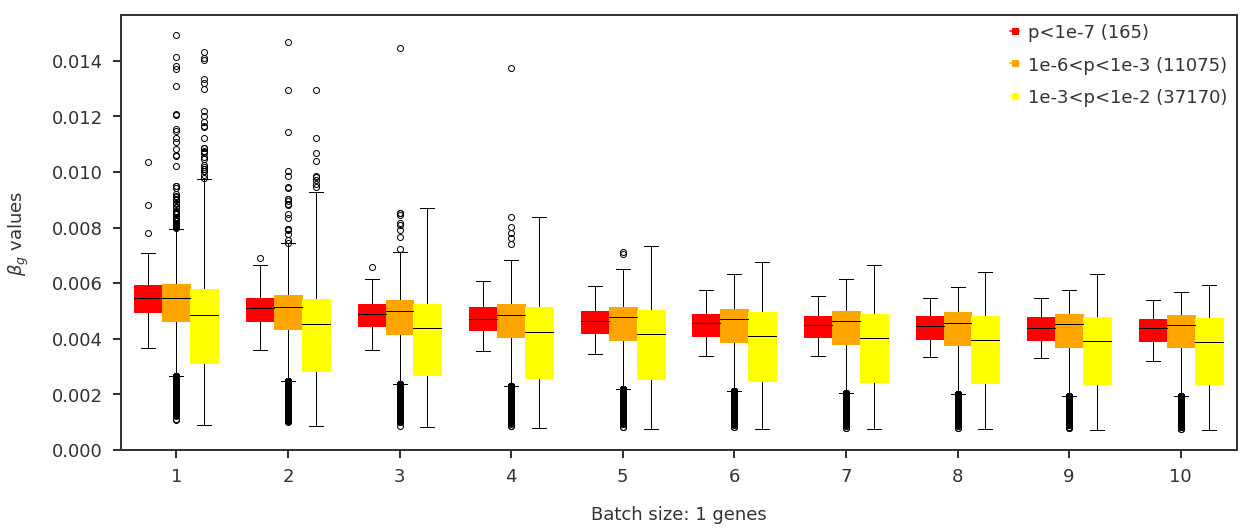

bins: 6769


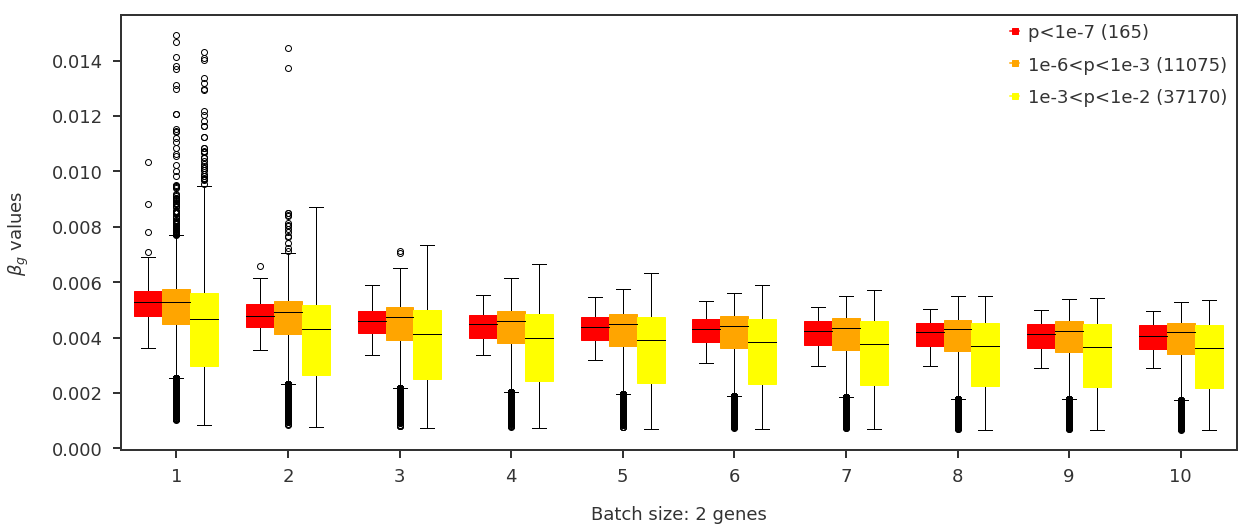

In [33]:
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

# chunksize = 100
for chunksize in [1,2]:
    nbins = int(ngenes/chunksize)
    print("bins:", nbins)

    fig = plt.figure(figsize=(20,8))
    ax  = fig.add_subplot(111)
    sorted_betas = np.flip(np.sort(np.abs(pruned_betas), axis=1), axis=1)
    # sorted_betas = np.flip(np.sort(norm_betas, axis=1), axis=1)
    # sorted_betas = np.sort(norm_betas, axis=1)

    groups = [t1, t2, t3]
    colors = ['red', 'orange', 'yellow']

    batches = 10
    pos = np.arange(0,batches*len(groups) + batches )

    size_label = list()
    for e,t in enumerate(groups): 
        chunks = list()
        tbetas = sorted_betas[t,:]
        size_label.append(len(t))

    #     for e,t in enumerate(ixpruned):   
    #     abs_ix = np.array([groups[e][i] for i in t])
    #     size_label.append(len(abs_ix))
    #     tbetas = sorted_betas[abs_ix, :]

        for i in range(batches):
            chunks.append(tbetas[:,i*chunksize:i*chunksize+chunksize].reshape(-1))
        xpos = [pos[j] for j in range(e, len(pos), 4)]
        colordict = dict(facecolor=colors[e], color=colors[e])
        ax.boxplot(chunks, positions=xpos, widths = 1.0, patch_artist=True, boxprops=colordict, medianprops=dict(color='black'))

    ax.set_xlim(-1,max(pos))
    ax.set_xticklabels(np.arange(1,batches+1))
    plt.xticks([pos[j] for j in range(1, len(pos), 4)])

    # draw temporary red and blue lines and use them to create a legend
    hR, = ax.plot([0.007, 0.007],'r-', marker='s')
    hO, = ax.plot([0.007, 0.007],color='orange', marker='s')
    hY, = ax.plot([0.007, 0.007],color='yellow', marker='s')
    ax.legend((hR, hO, hY),('p<1e-7 ({:d})'.format(size_label[0]), '1e-6<p<1e-3 ({:d})'.format(size_label[1]), '1e-3<p<1e-2 ({:d})'.format(size_label[2])))
    hR.set_visible(False)
    hO.set_visible(False)
    hY.set_visible(False)

    ax.set_ylabel(r'$ \beta_g $ values ')
    ax.set_xlabel("Batch size: {:d} genes".format(chunksize))
    plt.savefig("betas_distribution_GW_{:d}bs.png".format(chunksize))
    plt.show()

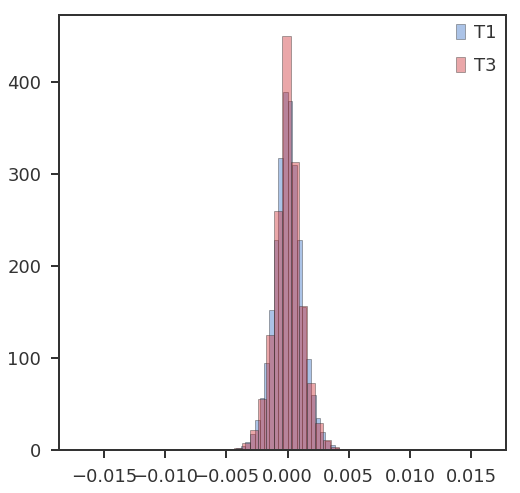

In [9]:
plt.hist(betas[t1,:].reshape(-1),density=True, bins=50, alpha=0.4, label="T1")
plt.hist(betas[t3,:].reshape(-1),density=True, bins=50, alpha=0.4, label="T3")
# plt.xlim(0.004, 0.006)
# plt.ylim(0, 20)
plt.legend()

plt.show()

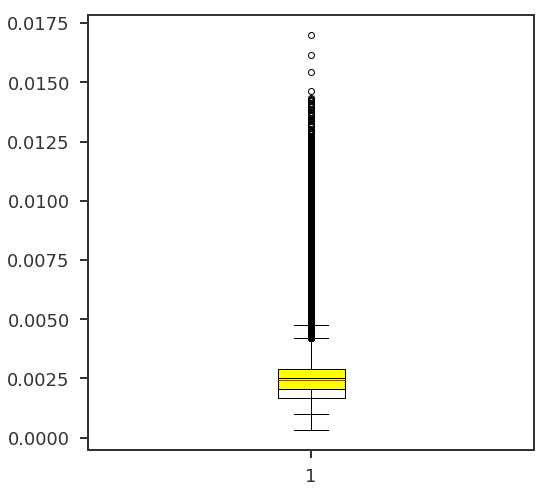

In [10]:
plt.boxplot(sorted_betas[t1,:1000].reshape(-1), patch_artist=True, boxprops=colordict, medianprops=dict(color='black'))
plt.boxplot(sorted_betas[t3,:1000].reshape(-1))
plt.show()

In [11]:
np.mean(np.std(betas, axis=1)[t3])

0.0010484096485178286

In [12]:
np.mean(np.std(betas, axis=1)[t1])

0.0011237157578987936